# HD현대 AI Challenge

## 배경

조선해양 분야 데이터를 기반으로 한 'HD현대 AI Challenge'를 개최됩니다.

코로나19 이후 물류 정체로 인해 다수의 항만에서 선박 대기 시간이 길어지고, 이로 인한 물류 지연이 화두가 되고 있습니다. 

특히 전 세계 물동량의 85%를 차지하는 해운 물류 분야에서 항만 정체는 큰 문제로 인식되고 있는 상황입니다. 

본 대회에서는 접안(배를 육지에 대는 것;Berthing) 전에 선박이 해상에 정박(해상에 닻을 바다 밑바닥에 내려놓고 운항을 멈추는 것;Anchorage)하는 시간을 대기시간으로 정의하고, 선박의 제원 및 운항 정보를 활용하여 산출된 항차(voyage; 선박의 여정) 데이터를 활용하여 항만 內 선박의 대기 시간을 예측하는 AI 알고리즘을 개발을 제안합니다.

이를 통해 선박의 접안 시간 예측이 가능해지고, 선박의 대기시간을 줄임으로써 연료 절감 및 온실가스 감축효과를 기대할 수 있습니다.

## 주제
항만 內 선박 대기 시간 예측을 위한 선박 항차 데이터 분석 AI 알고리즘 개발

## 설명

이번 ‘HD현대 AI Challenge’는 예선과 본선으로 진행됩니다.

예선은 Private 리더보드 점수를 바탕으로 본선 진출팀(학생 15팀)을 선발합니다. 본선은 새로운 과제와 데이터가 제공되며, 본선 과제 진행 후 오프라인 행사에서 최종 발표 평가를 통해 수상자를 선정합니다.

특별상(사내 우수 참가팀)은 예선으로만 평가하여 수상자를 선정합니다.

 (예선 과제) 선박의 여정 데이터로부터 항만 內 선박 대기 시간을 예측하는 AI 모델 개발

 (본선 과제) 예선 심사 이후 본선 진출팀 대상 개별 공개 예정


## 1. 라이브러리 및 데이터

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import joblib
import math
from tqdm import tqdm

from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from statsmodels.graphics.tsaplots import plot_acf, acf
from sklearn.linear_model import Ridge,Lasso,ElasticNet, LinearRegression, SGDRegressor, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC, SVR
from sklearn.compose import make_column_transformer,ColumnTransformer
import math
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics
from xgboost import XGBClassifier, XGBRFRegressor, XGBRegressor
# from lightgbm import LGBMRegressor

import matplotlib.font_manager as fm
# font_file_path_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# fav_font_file_path_lst = filter(lambda x: True if "BM" in x or "SDM" in x else False
#                                 , font_file_path_list)
# for font_file_path in fav_font_file_path_lst:
#     print(font_file_path)

# for key in plt.rcParamsDefault.keys():
#     if 'font' in key:
#         print("{}: {}".format(key, plt.rcParamsDefault[key]))

# font_path = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/0261f7b61f7cf2a9561694fc996a1e2ab9b517bb.asset/AssetData/BMDoHyeon-Regular.otf'
# font_name = fm.FontProperties(fname=font_path).get_name()

# matplotlib.rcParams['font.family'] = font_name
plt.rcParams['font.size'] = 14
matplotlib.rcParams['axes.unicode_minus'] = False
import warnings
warnings.simplefilter('ignore')


: 

In [ ]:
import xgboost as xgb 
import lightgbm as lgb
import bayes_opt
import itertools

from bayes_opt import BayesianOptimization

ImportError: cannot import name 'is_dtype_sparse' from 'lightgbm.compat' (/goinfre/chanwjeo/miniconda3/envs/42AI-chanwjeo/lib/python3.7/site-packages/lightgbm/compat.py)

In [21]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
train.head()


,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


In [22]:
categorical_features = [c for c, t in zip(train.dtypes.index, train.dtypes) if t == 'O']
numerical_features = [c for c in train.columns if c not in categorical_features]

print(f'categorical_features: {categorical_features}')
print(f'numerical_features: {numerical_features}')


categorical_features: ['SAMPLE_ID', 'ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ATA', 'ID', 'SHIPMANAGER', 'FLAG']
numerical_features: ['DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'CI_HOUR']


|Feature Name|Description|
|---|---|
|ARI_CO|도착항의 소속국가(도착항 앞 2글자)|
|ARI_PO|도착항의 항구명(도착항 뒤 글자)|
|SHIP_TYPE_CATEGORY|선종 통합 바탕으로 5대 선종으로 분류|
|DIST|정박지(ber_port)와 접안지 사이의 거리|
|ATA|anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival)|
|ID|선박식별 일련번호|
|BREADTH|선박의 폭|
|BUILT|선박의 연령|
|DEADWEIGHT|선박의 재화중량톤수|
|DEPTH|선박의 깊이|
|DRAUGHT|흘수 높이|
|GT|용적톤수(Gross Tonnage)값|
|LENGTH|선박의 길이|
|SHIPMANAGER|선박 소유주|
|FLAG|선박의 국적|
|U_WIND|풍향 u벡터|
|V_WIND|풍향 v벡터|
|AIR_TEMPERATURE|기온|
|BN|보퍼트 풍력 계급|
|ATA_LT|anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H)|
|PORT_SIZE|접안지 폴리곤 영역의 크기|
|CI_HOUR|대기시간|

## 2. 탐색적 자료분석

### 2.1 데이터 살펴보기

#### Feature 정보 확인

ARI_CO, ARI_PO는 도착항의 소속국가와 항구명을 나타내는 Feature이다. 이것을 토대로 군집을 나누는 것이 가능할 것으로 보인다.

SHIP_TYPE_CATEGORY는 선종 통합 바탕으로 5대 선종으로 분류한 Feature이다. 이것을 토대로 군집을 나누는 것이 가능할 것으로 보인다.

DIST는 정박지(ber_port)와 접안지 사이의 거리를 나타내는 Feature이다. 이것을 토대로 회귀분석을 진행하는 것이 가능할 것으로 보인다.

ATA는 anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival)을 나타내는 Feature이다. 이것을 윌 혹은 분기로 나누어서 군집을 형성하는것이 가능할 것으로 보인다.

ID는 선박식별 일련번호를 나타내는 Feature이다. ID 자체가 분석에 큰 영향을 미치지는 않을 것으로 보인다.

BREADTH는 선박의 폭을 나타내는 Feature이다. 선박의 폭은 선박의 크기를 나타내는 Feature이므로, 분석 결과에 영향을 미칠 것으로 보인다.

BUILT는 선박의 연령을 나타내는 Feature이다. 선박의 연령은 선박이 얼마나 오래되었는지 나타내는 Feature이므로, 분석 결과에 영향을 미칠 것으로 보인다. 선박의 연령이 높을수록 연비가 떨어지므로, 선박의 연령이 높을수록 대기시간이 길어질 것으로 예상된다.

DEATWEIGHT, DEPTH, DRAUGHT, GT, LENGTH는 선박의 재화중량톤수, 깊이, 흘수 높이, 용적톤수, 길이를 나타내는 Feature이다. 선박의 크기를 나타내는 Feature이고, 모두 양의 상관관계를 가질 것으로 예상된다.

SHIPMANAGER는 선박 소유주를 나타내는 Feature이다. 선박 소유주가 일치하는 데이터들의 대기시간이 비슷할 것으로 예상된다.

FLAG는 선박의 국적을 나타내는 Feature이다. 선박의 국적이 일치하는 데이터들의 대기시간이 비슷할 것으로 예상된다.

U_WIND, V_WIND, AIR_TEMPERATURE, BN은 ATA 시점 이전에 생성된 예보 데이터로, 정박 시점에 해당 선박의 위치로부터 가장 가까운 관측소의 예보 정보이다.

ATA_LT는 anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H)을 나타내는 Feature이다. 현지 정박 시간이 저녁 혹은 밤일 경우 대기시간이 길어질 것으로 예상된다.

PORT_SIZE는 접안지 폴리곤 영역의 크기를 나타내는 Feature이다. 접안지 폴리곤 영역의 크기와 대기시간의 상관관계를 체크해보자.

In [8]:
display(train.head().T, test.head().T)


,0,1,2,3,4
SAMPLE_ID,TRAIN_000000,TRAIN_000001,TRAIN_000002,TRAIN_000003,TRAIN_000004
ARI_CO,SG,IN,CN,JP,SG
ARI_PO,GIW5,UJM2,EUC8,ZAG4,GIW5
SHIP_TYPE_CATEGORY,Container,Bulk,Container,Container,Container
DIST,30.881018,0.0,0.0,0.0,27.03765
ATA,2018-12-17 21:29,2014-09-23 6:59,2015-02-03 22:00,2020-01-17 4:02,2020-01-26 7:51
ID,Z618338,X886125,T674582,Y847238,A872328
BREADTH,30.0,30.0,50.0,20.0,50.0
BUILT,24,13,12,18,10
DEADWEIGHT,24300,35900,146000,6910,116000


,0,1,2,3,4
SAMPLE_ID,TEST_000000,TEST_000001,TEST_000002,TEST_000003,TEST_000004
ARI_CO,SG,CN,CN,CA,JP
ARI_PO,GIW5,WEY7,NGG6,FFM2,QYY1
SHIP_TYPE_CATEGORY,Container,Cargo,Container,Bulk,Container
DIST,1.826589,25.399386,111.079467,9.175258,0.0
ATA,2020-06-18 11:58,2021-05-26 22:20,2019-12-16 0:09,2015-11-16 5:30,2018-10-24 1:11
ID,K322654,E376681,F811111,A737561,A827175
BREADTH,50.0,10.0,20.0,30.0,30.0
BUILT,18,13,26,9,19
DEADWEIGHT,117000,3810,10900,55800,39800


데이터의 상위 5개를 살펴보니, [U_WIND, V_WIND, AIR_TEMPERATURE, BN] Feature들 중에서 결측치를 가진 데이터가 존재한다. 이것을 어떻게 처리할지 고민해보자.

- 결측치를 제거하는 방법

현재, 상위 5개의 데이터 중, 2 ~ 3개의 데이터가 결측값을 가지고 있다. 이후에 결측치의 비율을 파악해봐야겠지만, 현재 상황을 봐서는 결측치를 제거한다면 데이터의 손실이 크게 발생할 것으로 예상된다.

- 결측치를 대체하는 방법

결측치를 대체하는 방법으로 같은 지역군에 위치하고, 같은 시간대에 생성된 데이터의 평균값으로 대체하는 방법을 생각해보고 있다. 다만, 기록된 날씨 정보가 결측값보다 적을 경우에는 다른 방법을 생각해보는것이 좋을 것 같다.


In [9]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           391939 non-null  object 
 1   ARI_CO              391939 non-null  object 
 2   ARI_PO              391939 non-null  object 
 3   SHIP_TYPE_CATEGORY  391939 non-null  object 
 4   DIST                391939 non-null  float64
 5   ATA                 391939 non-null  object 
 6   ID                  391939 non-null  object 
 7   BREADTH             391938 non-null  float64
 8   BUILT               391939 non-null  int64  
 9   DEADWEIGHT          391939 non-null  int64  
 10  DEPTH               391938 non-null  float64
 11  DRAUGHT             391938 non-null  float64
 12  GT                  391939 non-null  int64  
 13  LENGTH              391938 non-null  float64
 14  SHIPMANAGER         391939 non-null  object 
 15  FLAG                391939 non-nul

In [173]:
# 원본 DataFrame에서 결측값을 가지고 있는 행을 제거하려면
train_x = train.drop(['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'], axis = 1)

train_x.dropna()


,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,ATA_LT,PORT_SIZE,CI_HOUR
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,5,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,12,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,6,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,10.0,5400,120.0,PBZV77,Bahamas,13,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,10.0,96600,300.0,GUCE76,Liberia,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,TRAIN_391934,JP,QYY1,Container,0.000000,2017-06-06 5:02,Y375615,20.0,27,6820,10.0,10.0,4820,110.0,KEJZ24,"China, People's Republic Of",14,0.000552,0.000000
391935,TRAIN_391935,SG,GIW5,Bulk,5.884603,2019-10-16 0:36,K635567,10.0,12,3160,10.0,10.0,1600,80.0,JLTM64,Vietnam,8,0.002615,144.061389
391936,TRAIN_391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35,J284147,30.0,8,60300,20.0,10.0,34800,200.0,YERJ68,Singapore,18,0.000155,41.482222
391937,TRAIN_391937,TW,JWI3,Container,9.448179,2015-01-08 7:15,J644215,30.0,29,23800,10.0,10.0,16900,170.0,HCZK58,Comoros,15,0.000990,7.485278


In [11]:
train.describe().T


,count,mean,std,min,25%,50%,75%,max
DIST,391939.0,19.328187,30.930059,0.000000,0.000000,6.929678,25.692827,199.980651
BREADTH,391938.0,30.550010,10.957070,10.000000,20.000000,30.000000,40.000000,60.000000
BUILT,391939.0,14.747989,7.043988,0.000000,10.000000,13.000000,18.000000,80.000000
DEADWEIGHT,391939.0,63577.506780,63515.531024,100.000000,14300.000000,47400.000000,81500.000000,404000.000000
DEPTH,391938.0,16.476177,6.045930,0.000000,10.000000,20.000000,20.000000,30.000000
DRAUGHT,391938.0,11.088106,4.599298,0.000000,10.000000,10.000000,10.000000,20.000000
GT,391939.0,41348.968666,39304.543664,150.000000,10000.000000,30700.000000,52100.000000,237000.000000
LENGTH,391938.0,205.121320,75.873891,20.000000,150.000000,190.000000,260.000000,400.000000
U_WIND,228251.0,-0.294910,3.366585,-25.330000,-2.150000,-0.130000,1.540000,17.910000
V_WIND,228251.0,-0.263849,3.736949,-21.450000,-2.280000,0.000000,2.000000,29.690000


describe를 보니, [U_WIND, V_WIND, AIR_TEMPERATURE, BN] Feature들에게서 결측값이 존재하는것을 확인할 수 있다.

<Axes: xlabel='ATA_LT'>

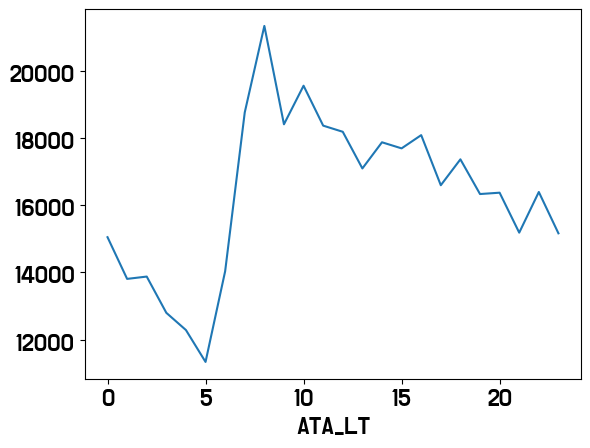

In [48]:
train.groupby(['ATA_LT']).size().plot()


Text(8.2, 21000, 'max')

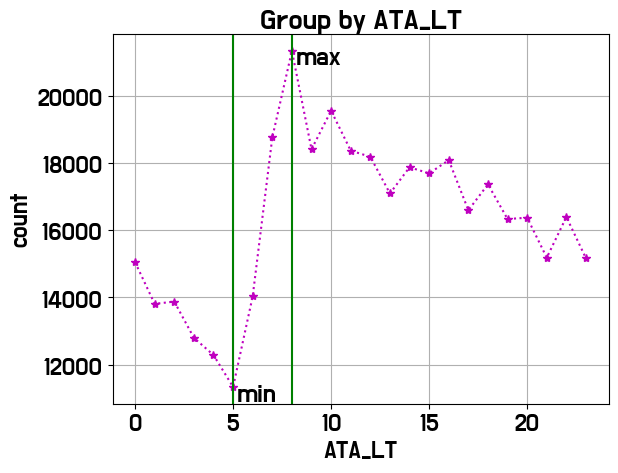

In [68]:
plt.plot(train.groupby(['ATA_LT']).size(), 'm*:')
plt.grid()
plt.title('Group by ATA_LT')
plt.xlabel('ATA_LT')
plt.ylabel('count')

plt.axvline(5, color = 'g')
plt.axvline(8, color = 'g')

plt.text(5.2, 11000, 'min', fontsize=15)
plt.text(8.2, 21000, 'max', fontsize=15)


'ATA_LT' feature를 통해 현지 정박 시각 별 선박의 수를 파악해볼 수 있다.

신기하게도 새벽 5시에 선박의 수가 가장 낮은 반면, 불과 3시간 만에 정박하는 선박의 수가 가장 많아진다.

개인적인 생각으로는 현지의 근로자들의 출근 시간이 8시로 가정했을 경우, 항구에 출근하면서 선박을 정박시키는 상황이 많이 발생하는것이 아닐까 하는 생각이 들었다.

그리고 동 시간 대에 정박하는 선박의 수가 많다면, 자연스럽게 선박의 대기시간도 증가할것이라 생각된다.

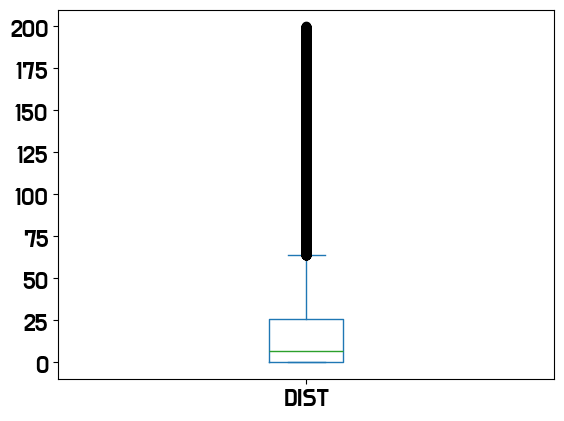

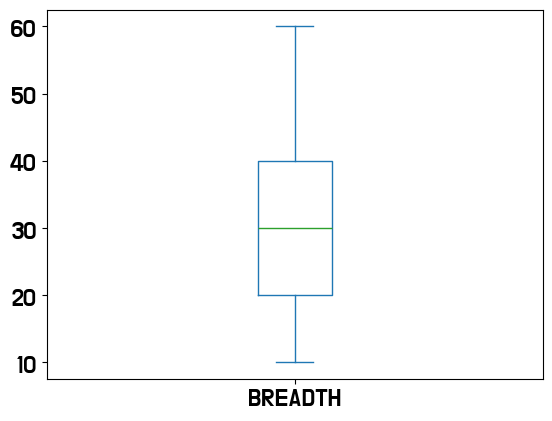

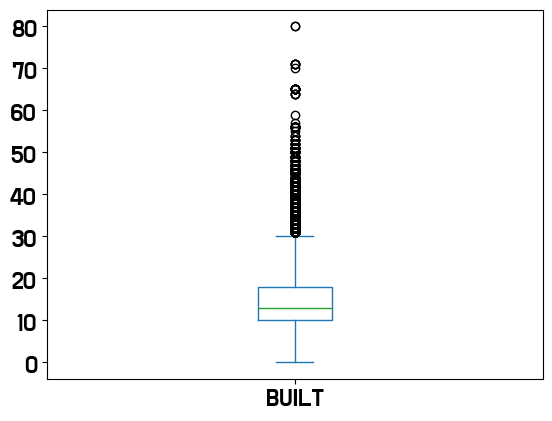

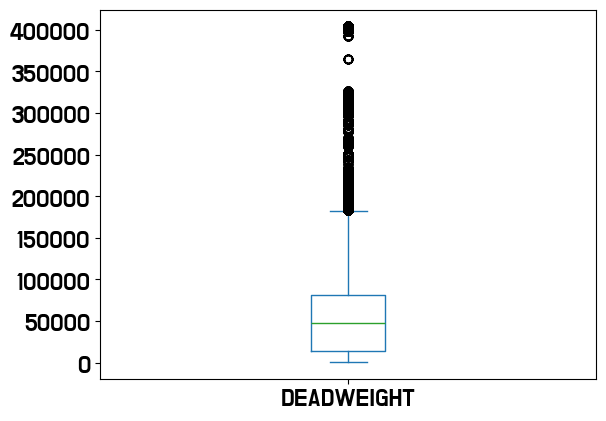

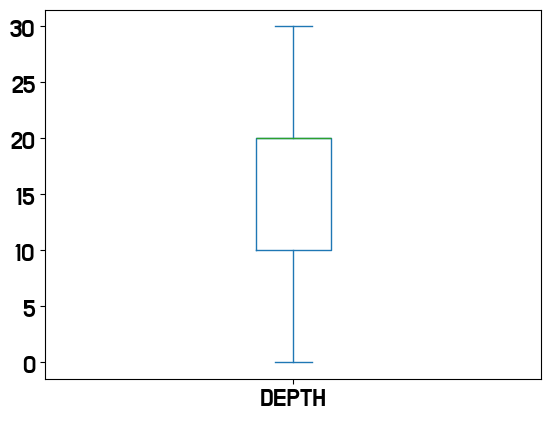

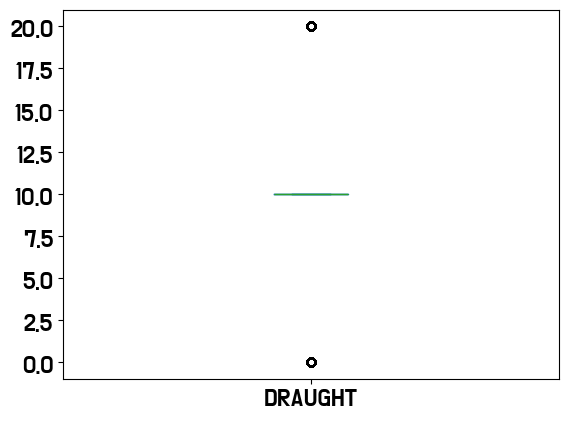

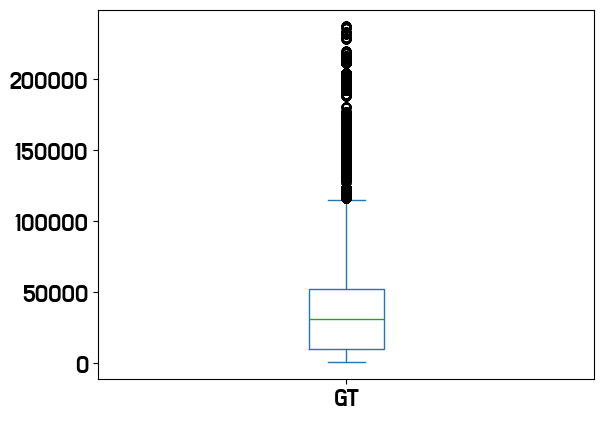

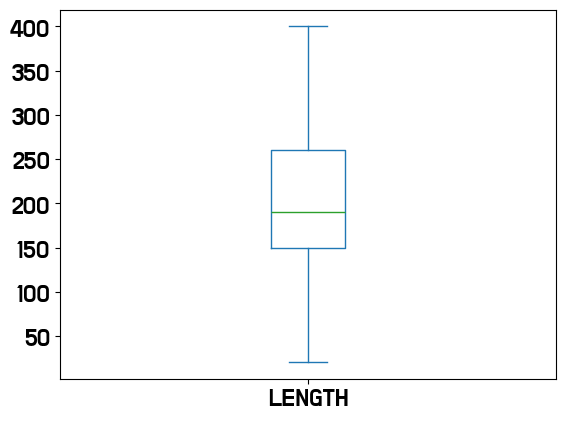

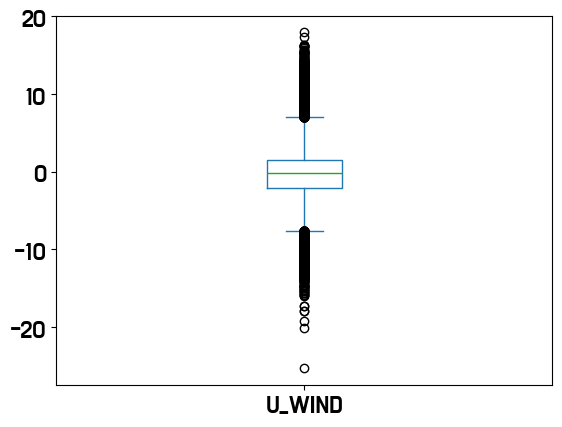

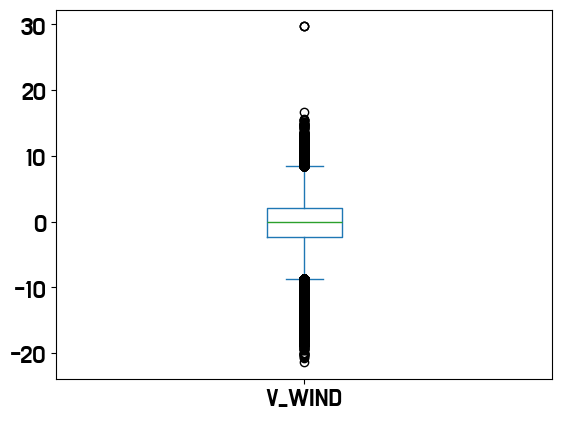

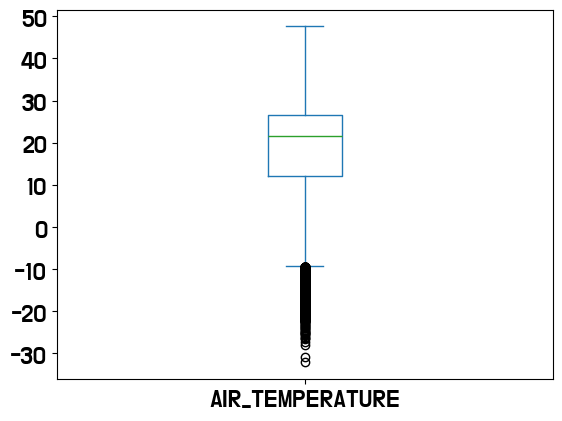

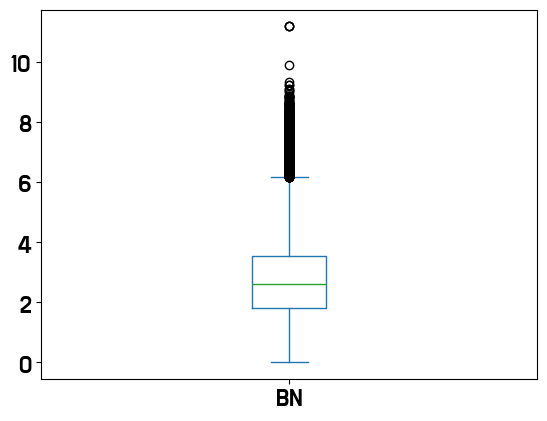

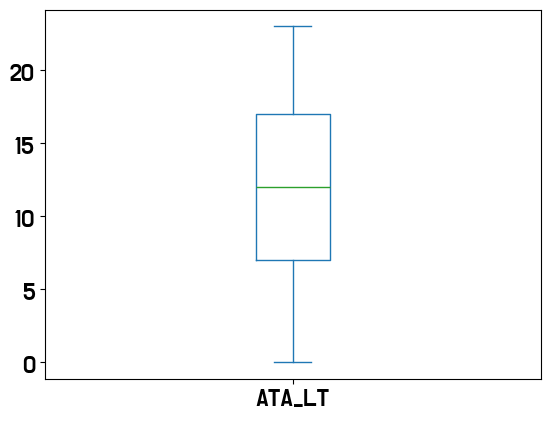

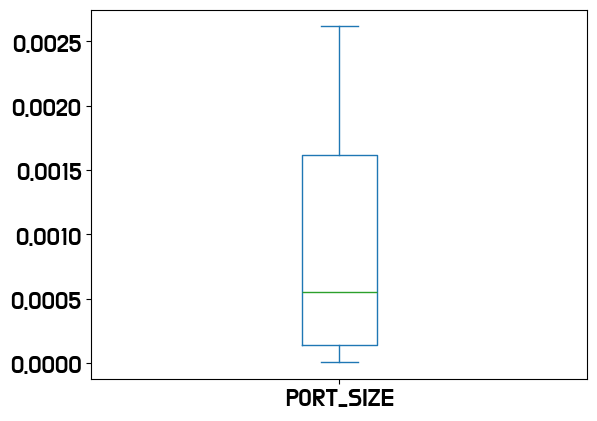

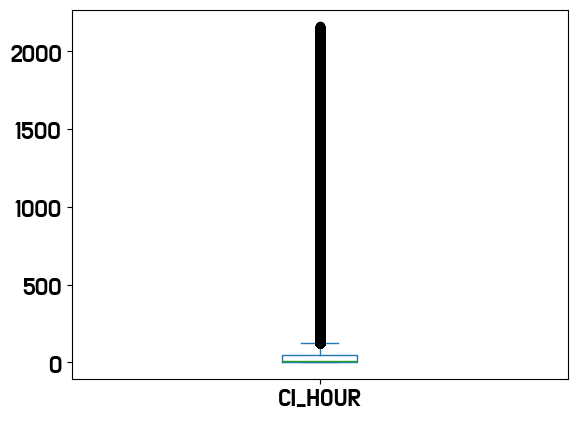

In [105]:
#박스 플롯 확인
for col in numerical_features:
    train[col].plot.box()
    plt.show()


In [106]:
categorical_features


['SAMPLE_ID',
 'ARI_CO',
 'ARI_PO',
 'SHIP_TYPE_CATEGORY',
 'ATA',
 'ID',
 'SHIPMANAGER',
 'FLAG']

In [114]:
display(train.groupby(['ARI_CO']).size().sort_values(ascending=False))


ARI_CO
CN    141743
JP     52752
SG     43865
AU     32853
TW     32616
IN     16192
RU     14383
CA     10890
KR     10644
BR      9374
ID      5863
US      4420
UA      3363
LV      2140
MZ      2122
QA      1809
ZA      1667
VN      1581
TT      1188
PE       904
MY       856
CL       267
FI       257
VE        97
PH        93
dtype: int64

## Data Pre-processing

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

categorical_features = [c for c, t in zip(train.dtypes.index, train.dtypes) if t == 'O']
numerical_features = [c for c in train.columns if c not in categorical_features]

print(f'categorical_features: {categorical_features}')
print(f'numerical_features: {numerical_features}')
# display(train.info())
# display(test.info())

categorical_features: ['SAMPLE_ID', 'ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
numerical_features: ['DIST', 'ATA', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'CI_HOUR', 'year', 'month', 'day', 'hour', 'minute', 'weekday']


In [5]:
# [U_WIND, V_WIND, AIR_TEMPERATURE, BN]를 제외한 컬럼들의 결측값을 제거 train에서는 1개, test는 제거할 결측값이 없음
train.dropna(subset=['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH'], inplace=True)
test.dropna(subset=['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH'], inplace=True)

# display(train.info())
# display(test.info())

In [6]:
# [U_WIND, V_WIND, AIR_TEMPERATURE, BN]에 대한 결측치 처리
for i, j, y, m in tqdm(train.groupby(['ARI_CO', 'ARI_PO', 'year', 'month']).count().index):
    mask = (train['ARI_CO'] == i) & (train['ARI_PO'] == j) & (train['year'] == y) & (train['month'] == m)
    train.fillna(train[mask].mean(), inplace=True)

for i, j, y, m in tqdm(test.groupby(['ARI_CO', 'ARI_PO', 'year', 'month']).count().index):
    mask = (test['ARI_CO'] == i) & (test['ARI_PO'] == j) & (test['year'] == y) & (test['month'] == m)
    test.fillna(test[mask].mean(), inplace=True)

display(train.info())
display(test.info())

100%|██████████| 9410/9410 [04:23<00:00, 35.76it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 391938 entries, 0 to 391938
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   SAMPLE_ID           391938 non-null  object        
 1   ARI_CO              391938 non-null  object        
 2   ARI_PO              391938 non-null  object        
 3   SHIP_TYPE_CATEGORY  391938 non-null  object        
 4   DIST                391938 non-null  float64       
 5   ATA                 391938 non-null  datetime64[ns]
 6   ID                  391938 non-null  object        
 7   BREADTH             391938 non-null  float64       
 8   BUILT               391938 non-null  int64         
 9   DEADWEIGHT          391938 non-null  int64         
 10  DEPTH               391938 non-null  float64       
 11  DRAUGHT             391938 non-null  float64       
 12  GT                  391938 non-null  int64         
 13  LENGTH              391938 no

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220491 entries, 0 to 220490
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   SAMPLE_ID           220491 non-null  object        
 1   ARI_CO              220491 non-null  object        
 2   ARI_PO              220491 non-null  object        
 3   SHIP_TYPE_CATEGORY  220491 non-null  object        
 4   DIST                220491 non-null  float64       
 5   ATA                 220491 non-null  datetime64[ns]
 6   ID                  220491 non-null  object        
 7   BREADTH             220491 non-null  float64       
 8   BUILT               220491 non-null  int64         
 9   DEADWEIGHT          220491 non-null  int64         
 10  DEPTH               220491 non-null  float64       
 11  DRAUGHT             220491 non-null  float64       
 12  GT                  220491 non-null  int64         
 13  LENGTH              220491 no

None

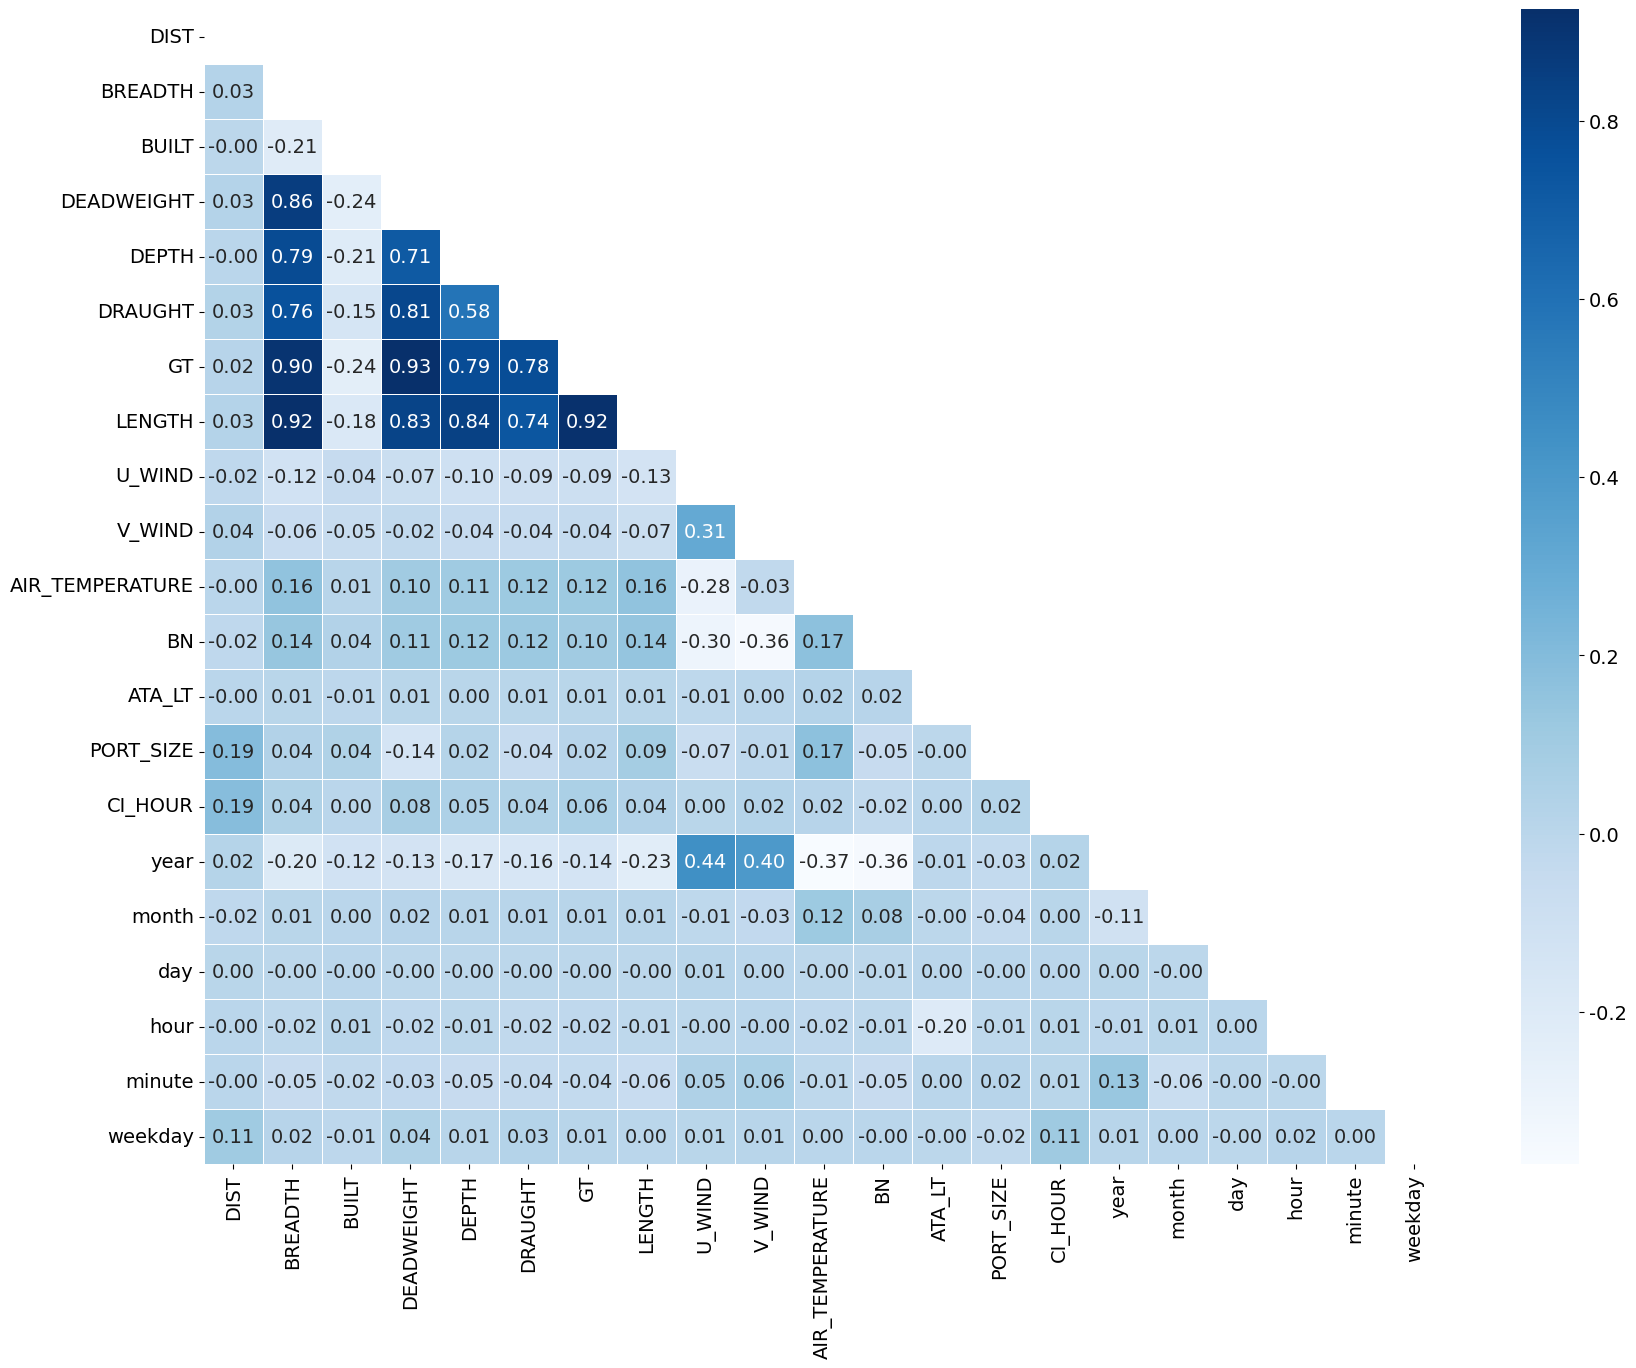

In [34]:
corr = train[numerical_features].corr()

plt.figure(figsize=(20, 15))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.5, cmap='Blues', mask=mask)
plt.show()


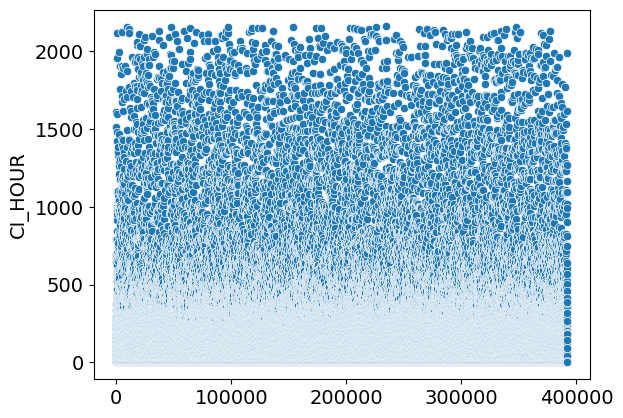

In [35]:
sns.scatterplot(train['CI_HOUR'])
plt.show()


In [150]:
train['CI_HOUR']


0           3.450000
1           0.000000
2           0.000000
3           0.000000
4         253.554444
             ...    
391934      0.000000
391935    144.061389
391936     41.482222
391937      7.485278
391938      0.000000
Name: CI_HOUR, Length: 391939, dtype: float64

## Create Model

In [183]:
train_x = train[numerical_features].drop(['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'], axis=1)

train_x = train_x.dropna()
target = train_x['CI_HOUR']
train_x = train_x.drop(['CI_HOUR'], axis=1)


In [184]:
x_train, x_test, y_train, y_test = train_test_split(train_x, target, test_size=0.2, random_state=42)


In [185]:
def model_train(x_train, y_train, x_valid, y_valid) :
    params = {'learning_rate': 0.01, 
              'objective': 'regression',  
              'metric':'mae',
              'seed':42
             }

    
    model = lgb.train(params, 
                           categorical_feature = ['year', 'month', 'day', 'weekday', '시간'],
                           train_set = lgb.Dataset(data = x_train, label = y_train),
                           num_boost_round = 10000,
                           valid_sets = lgb.Dataset(data = x_valid, label = y_valid), 
                           init_model = None, 
                           early_stopping_rounds = 100,
                           verbose_eval = 50
                          )
    
    return model